# Set up

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!cp /content/drive/MyDrive/MMDS/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [5]:
import findspark
findspark.init()

# Main libraries

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, array
import pyspark.sql.functions as F
from pyspark.sql.types import *
from collections import defaultdict
import numpy as np
from sklearn.cluster import AgglomerativeClustering

# Load dataset

In [7]:
spark = SparkSession.builder.appName("Experiment").getOrCreate()

In [8]:
import os

path = "/content/drive/MyDrive/MMDS/Endterm/Question2/embedding.json"

if os.path.exists(path):
    print("Path exists!")
else:
    print("Path does not exist.")

Path exists!


In [9]:
df = spark.read.json(path)

In [10]:
df.show(5)

+--------------------+-------+
|           embedding|user_id|
+--------------------+-------+
|[-16.796118656868...|     31|
|[-0.1880540258735...|     65|
|[-2.3890451791994...|     53|
|[-1.9212580037324...|     34|
|[-4.3522241197278...|     28|
+--------------------+-------+
only showing top 5 rows



# Class

In [11]:
class CURE:
    def __init__(self,
        n_cluster=5, # number of clusters
        n_reps=5,  # number of representatives per cluster
        shrink_factor=0.2,  # shrink representatives by 20%
        sample_fraction=0.25,  # sampling fraction for first pass
        merge_threshold=0.3,  # representatives merging threshold
    ):
        self.n_cluster = n_cluster
        self.n_reps = n_reps
        self.shrink_factor = shrink_factor
        self.sample_fraction = sample_fraction
        self.merge_threshold = merge_threshold

    def euclidean_distance(self, point1, point2) -> float:
        """
        Compute Euclidean distance between two points

        Params:
            point1: First point (array or list)
            point2: Second point (array or list)

        Return:
            Euclidean distance
        """
        return np.linalg.norm(np.array(point1) - np.array(point2))

    def compute_centroid(self, points) -> list[float]:
        return [
            sum(point[i] for point in points) / len(points)
            for i in range(len(points[0]))
        ]

    def choose_reps(self, centroid, points) -> list[list[float]]:
        """
        Select reps for a cluster using furthest point heuristic

        Params:
            centroid: List of doubles
            points: List of points in the cluster
        Return:
            Choose reps for a cluster
        """

        # In case the cluster contains fewer points
        if len(points) <= self.n_reps:
            return points

        # Otherwise, using Maximize minimum distances to choose reps
        reps = [centroid]
        for _ in range(self.n_reps):
            point_A_minimum_distances = []
            for point in points:

                if point in reps:
                    continue


                point_A_minimum_distances.append(
                    (
                        point,
                        min([self.euclidean_distance(rep, centroid)
                            for rep in reps])
                    )
                )

            rep, distance = max(point_A_minimum_distances, key=lambda x: x[1])
            reps.append(rep)

        return reps[1:]

    def shrink_reps(self, reps, centroid) -> list[list[float]]:
        """
        Shrink reps towards cluster centroid

        Params:
            reps: List of representatives
            centroid: Cluster centroid, List of doubles

        Return:
            Shrunken reps
        """
        shrunken_reps = [
            [
                rep_coords + self.shrink_factor * (rep_coords - centroid_coords)
                for rep_coords, centroid_coords in zip(rep, centroid)
            ]
            for rep in reps
        ]

        return shrunken_reps

    def merge_close_clusters(self, clusters) -> list[dict]:
        """
        Perform CURE clustering

        Params:
            clusters: List of dict{cluster_id, centroid, points, reps}
        Return:
            New clusters, include merged clusters and unmerged clusters.
            List of dict{cluster_id, reps}
        """

        # Initialize a parent-child mapping
        merge_map = defaultdict(list)

        for i, cluster1 in enumerate(clusters):
            for j, cluster2 in enumerate(clusters[i+1:], start=i+1):
                # Check if the clusters are close

                if any(
                    self.euclidean_distance(rep1, rep2) <= self.merge_threshold
                    for rep1 in cluster1['reps']
                    for rep2 in cluster2['reps']
                ):

                    merge_map[cluster1['cluster_id']].append(cluster2['cluster_id'])

        # Convert merge_map into list of tuples (merged groups)
        merged_groups = []
        visited = set()

        def gather_group(cluster_id):
            # Recursively gather all children of a cluster.
            if cluster_id in visited:
                return []
            visited.add(cluster_id)
            group = [cluster_id]
            for child in merge_map.get(cluster_id, []):
                group.extend(gather_group(child))
            return group

        # List of tuples, each tuple contains merge_cluster_id s
        for cluster_id in merge_map:
            if cluster_id not in visited:
                merged_groups.append(tuple(gather_group(cluster_id)))

        # Combine clusters in merged_groups
        merged_clusters = []
        merged_ids = set()

        id = 0 # to re-numbered the cluster id
        for group in merged_groups:
            merged_ids.update(group)
            new_reps = []
            for cluster_id in group:
                new_reps.extend(clusters[cluster_id]['reps'])

            merged_clusters.append({
                'cluster_id': id,
                'reps': new_reps
            })
            id += 1

        unmerged_clusters = []

        for cluster in clusters:
            if cluster['cluster_id'] not in merged_ids:
                unmerged_clusters.append({"cluster_id": id,
                                        "reps": cluster["reps"]})
                id += 1

        return merged_clusters + unmerged_clusters

    def agglomerative_clustering(self, data):
        """
        Perform Agglomerative Clustering

        Params:
            data: Numpy array of points

        Return:
            Cluster assignments
        """
        clustering = AgglomerativeClustering(n_clusters=self.n_cluster,
                                            linkage="ward")
        cluster_labels = clustering.fit_predict(data)

        return cluster_labels


    def pass1(self, dataframe, featureCol):
        # Sampling, List of PySpark's Row
        sample = dataframe.sample(False, self.sample_fraction).collect()

        # Converting to NumPy for input of Aggl. clustering
        np_sample_points = np.array([np.array(row[featureCol])
                                        for row in sample])

        # Aggl. clustering, return NumPy array of labels
        # that coorespond to each point
        cluster_labels = self.agglomerative_clustering(np_sample_points)

        # Group by cluster label, and covert to list for each point
        n = len(cluster_labels)
        cluster_id_A_points = defaultdict(list)
        for i in range(n):
            cluster_id_A_points[cluster_labels[i]].append(
                                            np_sample_points[i].tolist())

        # List of clusters, dict
        processed_clusters = []
        for cluster_id, points in list(cluster_id_A_points.items()):

            centroid = self.compute_centroid(points)
            reps = self.choose_reps(centroid, points)
            shrunken_reps = self.shrink_reps(reps, centroid)

            processed_clusters.append({
                "cluster_id": cluster_id,
                "centroid": centroid,
                "points": points,
                "reps": shrunken_reps,
            })

        return self.merge_close_clusters(processed_clusters)



    def pass2(self, dataframe, featureCol, new_clusters):

        # Create User-defined function
        def assign_point_to_cluster_id(point, clusters):
            cluster_id_A_min_dist = []
            for cluster in clusters:

                rep, min_dist = min([
                            (
                                rep,
                                np.linalg.norm(np.array(point) - np.array(rep))
                            )
                            for rep in cluster["reps"]], key=lambda x: x[1])

                cluster_id_A_min_dist.append((cluster["cluster_id"],
                                              rep, min_dist))

            cluster_id, rep, min_dist = min(cluster_id_A_min_dist,
                                            key=lambda x: x[2])
            return cluster_id, rep

        # Register
        assign_point_to_cluster_id_udf = F.udf(
            lambda point: assign_point_to_cluster_id(point, new_clusters),
            StructType([
                StructField("cluster_id", IntegerType()),
                StructField("rep", ArrayType(DoubleType()))
            ])
        )

        return (dataframe.withColumn("tmp",
        assign_point_to_cluster_id_udf(F.col(featureCol)))
        .select("tmp.cluster_id", F.col(featureCol).alias("point"), "tmp.rep"))


    def fit_transform(self, dataframe, featureCol="embedding"):
        new_clusters = self.pass1(dataframe, featureCol)
        result_df = self.pass2(dataframe, featureCol, new_clusters)

        return result_df

# Testing

In [12]:
cure = CURE()
result = cure.fit_transform(df, featureCol="embedding")

In [13]:
result.show(10)

+----------+--------------------+--------------------+
|cluster_id|               point|                 rep|
+----------+--------------------+--------------------+
|         4|[-16.796118656868...|[-13.595301929171...|
|         0|[-0.1880540258735...|[0.57158091518525...|
|         0|[-2.3890451791994...|[-2.0696084688059...|
|         0|[-1.9212580037324...|[0.57158091518525...|
|         0|[-4.3522241197278...|[-4.4254231974399...|
|         4|[-9.0957539728547...|[-7.4388935529355...|
|         0|[-4.3722830580566...|[0.57158091518525...|
|         0|[-0.9598459091748...|[0.57158091518525...|
|         1|[-28.912229574723...|[-28.912229574723...|
|         0|[-8.7604340796836...|[0.17583138119460...|
+----------+--------------------+--------------------+
only showing top 10 rows



# Compute average distance
Average distance from point to its closest rep, for number of reps is in range [3, 8]

In [14]:
def distance(rep, point):
    # Check for None or arrays of different lengths
    if rep is None or point is None or len(rep) != len(point):
        return None

    # Compute Euclidean distance
    return float(np.sqrt(sum((a - b) ** 2 for a, b in zip(rep, point))))

distance_udf = F.udf(lambda rep, point: distance(rep, point),
                               DoubleType())

In [15]:
avgs = []
for n_reps in range(3, 9):
    cure = CURE(n_reps=3)
    result = cure.fit_transform(df, featureCol="embedding")
    avg = (result.withColumn("distance",
            distance_udf(F.col("rep"), F.col("point")))
            .select(F.mean(F.col("distance")).alias("average")))
    avg.show()
    avgs.append(avg.collect()[0]["average"])

+------------------+
|           average|
+------------------+
|14.333434423380115|
+------------------+

+------------------+
|           average|
+------------------+
|13.894271290969742|
+------------------+

+------------------+
|           average|
+------------------+
|14.280913028098047|
+------------------+

+------------------+
|           average|
+------------------+
|14.796031386379667|
+------------------+

+------------------+
|           average|
+------------------+
|16.362716081739585|
+------------------+

+------------------+
|           average|
+------------------+
|14.434704299017278|
+------------------+



## Bar plot

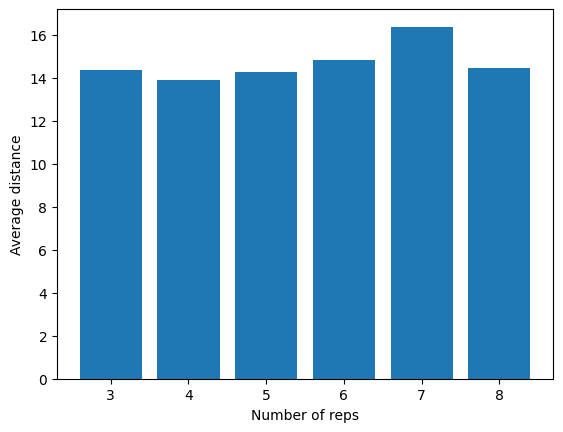

In [17]:
from matplotlib import pyplot as plt
plt.bar(range(3, 9), avgs)
plt.xlabel("Number of reps")
plt.ylabel("Average distance")
plt.show()